# Modeling and Simulation in Python

Chapter 17

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Data

We have data from Pacini and Bergman (1986), "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122..

In [3]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time')

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51
10,216,49
12,211,45
14,205,41
16,196,35


Here's what the glucose time series looks like.

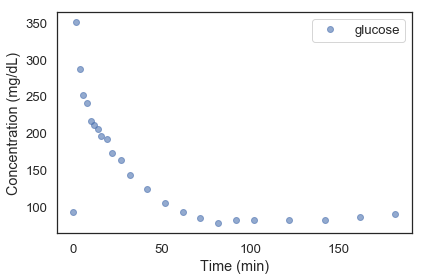

In [4]:
plot(data.glucose, 'bo', label='glucose')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

And the insulin time series.

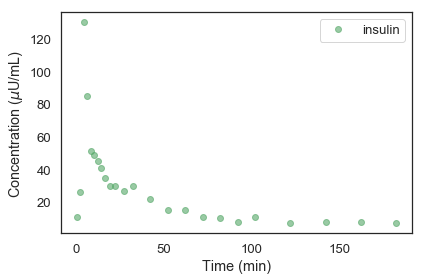

In [5]:
plot(data.insulin, 'go', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

For the book, I put them in a single figure, using `subplot`

Saving figure to file figs/chap08-fig01.pdf


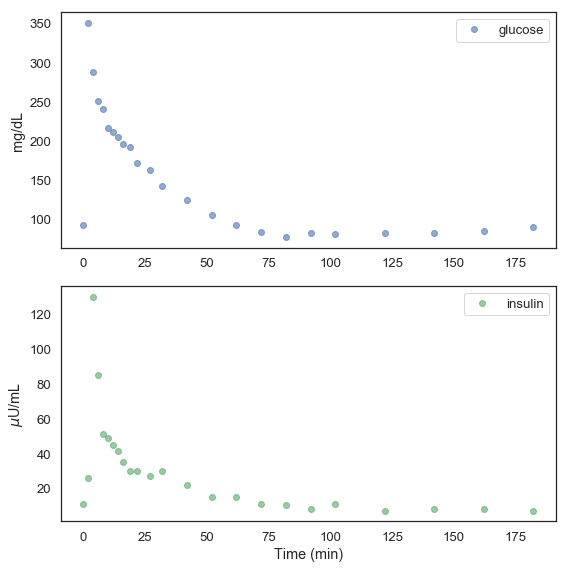

In [6]:
subplot(2, 1, 1)
plot(data.glucose, 'bo', label='glucose')
decorate(ylabel='mg/dL')

subplot(2, 1, 2)
plot(data.insulin, 'go', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='$\mu$U/mL')

savefig('figs/chap08-fig01.pdf')

### Interpolation

We have measurements of insulin concentration at discrete points in time, but we need to estimate it at intervening points.  We'll use `interpolate`, which takes a `Series` and returns a function:

The return value from `interpolate` is a function.

In [25]:
I = interpolate(data.insulin, copy=False)

We can use the result, `I`, to estimate the insulin level at any point in time.

In [26]:
I(7)

array(68.)

`I` can also take an array of time and return an array of estimates:

In [27]:
t_0 = get_first_label(data)
t_end = get_last_label(data)
ts = linrange(t_0, t_end, endpoint=True)
I(ts)
type(ts)

numpy.ndarray

Here's what the interpolated values look like.

Saving figure to file figs/chap08-fig02.pdf


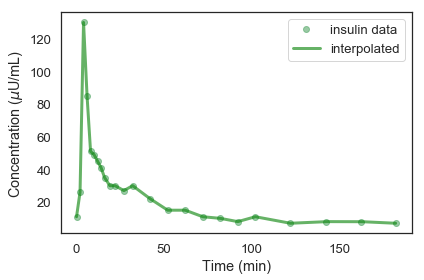

In [28]:
plot(data.insulin, 'go', label='insulin data')
plot(ts, I(ts), color='green', label='interpolated')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

savefig('figs/chap08-fig02.pdf')

**Exercise:** [Read the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) of `scipy.interpolate.interp1d`.  Pass a keyword argument to `interpolate` to specify one of the other kinds of interpolation, and run the code again to see what it looks like. 

### The glucose minimal model

I'll cheat by starting with parameters that fit the data roughly; then we'll see how to improve them.

In [11]:
params = Params(G0 = 290,
                k1 = 0.03,
                k2 = 0.02,
                k3 = 1e-05)

,values
G0,290.00000
k1,0.03000
k2,0.02000
k3,0.00001


Here's a version of `make_system` that takes the parameters and data:

In [12]:
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(G=G0, X=0)
    
    return System(G0=G0, k1=k1, k2=k2, k3=k3,
                  init=init, Gb=Gb, Ib=Ib,
                  t_0=t_0, t_end=t_end, dt=2)

In [13]:
system = make_system(params, data)

,values
G0,290
k1,0.03
k2,0.02
k3,1e-05
init,G 290.0 X 0.0 dtype: float64
Gb,92
Ib,11
t_0,0
t_end,182
dt,2


And here's the update function.  It uses `unpack` to make the system variables accessible without using dot notation, which makes the translation of the differential equations more readable and less error prone.

In [14]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    unpack(system)
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

Before running the simulation, it is always a good idea to test the update function using the initial conditions.  In this case we can veryify that the results are at least qualitatively correct.

In [15]:
update_func(system.init, system.t_0, system)

,values
G,278.12
X,0.00


Now `run_simulation` is pretty much the same as it always is.

In [16]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

And here's how we run it.  `%time` is a Jupyter magic command that runs the function and reports its run time.

In [17]:
%time results = run_simulation(system, update_func);

Wall time: 294 ms


The results are in a `TimeFrame object` with one column per state variable.

In [18]:
results

,G,X
0,290.000000,0.000000
2,278.120000,0.000000
4,266.952800,0.000300
6,256.295460,0.002668
8,245.070140,0.004041
10,233.905138,0.004680
12,223.201651,0.005252
14,212.984844,0.005722
16,203.288207,0.006093
18,194.133461,0.006330


The following plot shows the results of the simulation along with the actual glucose data.

Saving figure to file figs/chap08-fig03.pdf


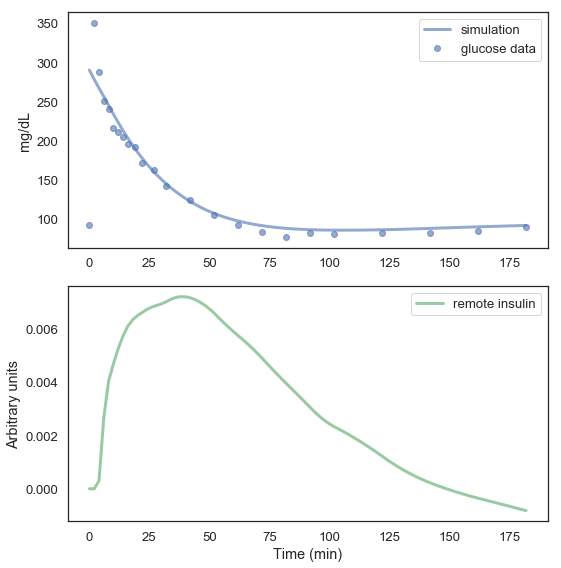

In [19]:
subplot(2, 1, 1)

plot(results.G, 'b-', label='simulation')
plot(data.glucose, 'bo', label='glucose data')
decorate(ylabel='mg/dL')

subplot(2, 1, 2)

plot(results.X, 'g-', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Arbitrary units')

savefig('figs/chap08-fig03.pdf')

### Under the hood

In [20]:
%psource interpolate

### Exercises

**Exercise:**  Our solution to the differential equations is only approximate because we used a finite step size, `dt=2` minutes.

If we make the step size smaller, we expect the solution to be more accurate.  Run the simulation with `dt=1` and compare the results.  What is the largest relative error between the two solutions?

In [30]:
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(G=G0, X=0)
    
    return System(G0=G0, k1=k1, k2=k2, k3=k3,
                  init=init, Gb=Gb, Ib=Ib,
                  t_0=t_0, t_end=t_end, dt=1)

In [31]:
system = make_system(params, data)
tnew = run_simulation(system, update_func)

,G,X
0,290.000000,0.000000
1,284.060000,0.000000
2,278.298200,0.000075
3,272.688382,0.000224
4,267.206784,0.000889
5,261.713026,0.002061
6,256.082179,0.002985
7,250.395302,0.003665
8,244.725663,0.004162
9,239.125341,0.004479


Saving figure to file figs/chap08-fig03.pdf


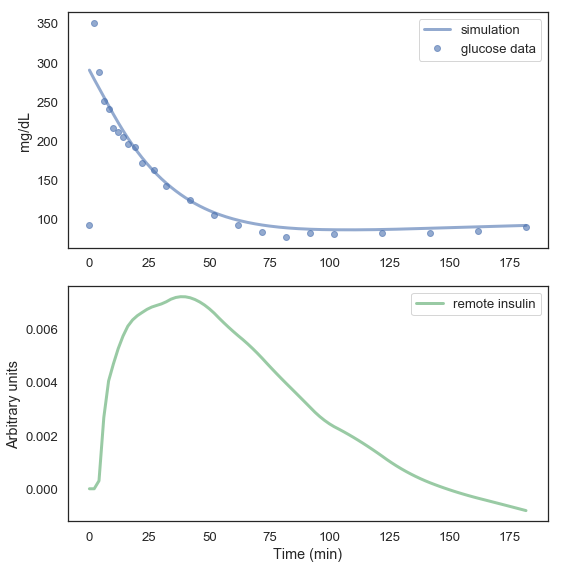

In [32]:
subplot(2, 1, 1)

plot(tnew.G, 'b-', label='simulation')
plot(data.glucose, 'bo', label='glucose data')
decorate(ylabel='mg/dL')

subplot(2, 1, 2)

plot(results.X, 'g-', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Arbitrary units')

savefig('figs/chap08-fig03.pdf')

In [24]:
# Solution goes here